# Static Hedging of Impermanent Loss in CPMM

## Theoretical Formulation

### Scopes

<a name="alcances">Note:</a>

In this paper, we will limit ourselves to a static study of the issue, which is why we will only have one initial and one final time, without any intermediate steps.

We assume, except where clarified, that the quantities in the pool between the initial and final times remain unchanged by the product constant 𝑘 .

We also assume that the pool is initially formed with quantities that do not allow arbitrage.

We do not consider fees in the calculation of Impermanent Loss, although we include a brief discussion of the issue in Appendix II. The details of the calculation and the integration of the functions with the rest of the code are beyond the scope of this paper for reasons of both time and clarity.

### Composition and valuation of the pool

A pool $Q$ of two currencies X, Y can be represented as a vector containing, at time $T$, quantities $x$ and $y$ respectively:

$$ \vec Q_T = (x, y) $$

The pool is originally formed with initial quantities $\vec Q_0=(x_0, y_0)$ balanced with respect to the prices at that time.

To value the pool, we must add the valuation of its reserves. That is, given a valuation vector $\vec P_t$ at time $t$, the value of the pool $Q_t$ is the following dot product:

$$V_{Q_t}(P_t) = \vec Q_t \cdot \vec P_t$$

To value the reserves $(x,y)$ with the vector $\vec P_t$, we can value both reserves in terms of one of them (e.g., $Y$), or both in terms of a third currency $Z$. If we note the price of $X$ measured in units of $Y$ as $P_{Y|X}$, we have:

* Valuation vector in terms of $Y$: $\vec P = (P_{Y|X}, P_{X|X}) = (P_{Y|X}, 1) $
* Valuation vector in terms of $Z$: $\vec P = (P_{Z|X}, P_{Z|Y}) = P_{Z|Y} \cdot (P_{Y|X}, 1) $

Therefore, valuing in a third currency simply requires applying a factor. Therefore, we will simplify the calculations using the valuation in terms of $Y$. From now on, we will use the price $P_{Y|X}$, which we will simply call $P$, since there is no confusion with the valuation vector $\vec P$. As this price varies with time $t$, we will notice $\vec P_t$.


In [2]:
import numpy as np
#np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
# np.warnings.filterwarnings('error', category=np.VisibleDeprecationWarning)

# Initial implicit price (because we assume no arbitrage)
def get_pool_initial_price(balances: tuple) -> float:
    return balances[1]/balances[0]

def get_pool_price_units(symbols: tuple) -> str:
    return symbols[1]

def get_initial_prices_vector(balances: tuple) -> tuple:
    return (get_pool_initial_price(pool_balances), 1) # pool prices measured in units of pool_symbols[1]

def get_prices_vector(price: float) -> tuple:
    return (price, 1)

# Function that, given a pool and a vector of prices, returns the value of the given pool.
def get_pool_value(balances: tuple, prices: tuple) -> float:
    return float(np.dot(balances, prices))



### Impermanent Loss

In its simplest form, Impermanent Loss arises from subtracting two values:
* The time value $t$ of the quantities $\vec Q_t$ existing in the pool, using their prices $\vec P_t$.
$$V_{Pool_t} = V_{Q_t}(P_t) = \vec Q_t \cdot \vec P_t$$
* The time value $t$ of the initial quantities in the pool, $\vec Q_0$, as if we still held them outside the pool, valued at their time prices $t$.
$$V_{Hold_t} = V_{Q_0}(P_t) = \vec Q_0 \cdot \vec P_t$$

The impermanent loss expressed in terms of the prices $\vec P_t$ at time $t$ is then:

$$IL(\vec P_t) = V_{Pool_t} - V_{Hold_t} = (\vec Q_t-\vec Q_0) \cdot \vec P_t $$

$$ = (x-x_0, y-y_0) \cdot (P, 1)$$

$$ = (x-x_0)P + (y-y_0) $$

But since the idea is to hedge against the change in IL with respect to changes in price, we must express it as a function of $P$ by removing the existing amounts in the pool from the middle. To do this, we formulate $V_{Pool}$ and $V_{Hold}$ differently using the following identities (see reference bibliography \[[1](#reference1)\]):

\begin{align*}
  Ec.\ 1\ :\ \ \ \ y_t &= \sqrt{k\ P_t} \\
  Ec.\ 2\ :\ \ \ \ V_{Pool_0} &= V_{Hold_0} = 2 \sqrt{k P_0} \\
  Ec.\ 3\ :\ \ \ \ P_0 &= y_0 / x_0 \\
  Ec.\ 4\ :\ \ \ \ V_{Pool_T} &= 2 \sqrt{k P_T} \\
\end{align*}

By Eq. 4 we have:

$$ V_{Pool} = 2\sqrt{kP} $$
$$ = \frac{2\sqrt{kP_0 P}}{\sqrt{P_0}} $$
$$ = 2\sqrt{kP_0} \sqrt{\frac{P}{P_0}} $$
$$ [Eq.\ 2]\ \ \ = V_{Pool_0}\sqrt{\frac{P}{P_0}} $$

And by the definition we gave, we have:
$$ V_{Hold} = \vec Q_0 \cdot \vec P_t = (x_0, y_0) \cdot (P, 1) = x_0 P + y_0 $$

$$ [Eq.\ 1]\ \ \ \ \ \ = x_0 P + \sqrt{k P_0} $$

$$ [Eq.\ 3]\ \ \ = \frac{y_0}{P_0} P + \sqrt{k P_0} $$

$$ [Eq.\ 1]\ \ \ \ \ \ = \frac{\sqrt{k P_0}}{P_0} P + \sqrt{k P_0} $$

$$ = \sqrt{k P_0} (\frac{P}{P_0} + 1 )$$

$$ = 2\sqrt{kP_0}\frac{1}{2}(\frac{P}{P_0}+1) $$
$$ [Eq.\ 2]\ \ \ \ \ \ =\frac{V_{Hold_0}}{2}(\frac{P}{P_0}+1) $$

We are then left with the following Impermanent Loss formula expressed in terms of prices whose unit is the currency $Y$:

$$IL_Y(P) = V_{Pool} - V_{Hold} $$
$$ = V_{Pool_0}\sqrt{\frac{P}{P_0}} - \frac{V_{Hold_0}}{2}(\frac{P}{P_0}+1)$$

$$ [Eq.\ 2]\ \ \ \ \ \  = V_{Hold_0}\left(\sqrt{\frac{P}{P_0}}-\frac{1}{2} (\frac{P}{P_0}+1)\right) $$

$$ = V_{Hold_0}\left(\sqrt{\frac{P}{P_0}}-\frac{1}{2}-\frac{P}{2P_0}\right)$$



In [3]:
# Impermanent Loss expressed in currency Y as a function of P without fees
def IL_Y_P(P: any, balances: tuple) -> any:
    if type(P) == float or type(P) == np.float64 or type(P) == int:
        # If P is a number, return a float
        P_entry = get_pool_initial_price(balances)
        V_hold_0 = get_pool_value(balances, get_prices_vector(P_entry))
        return V_hold_0 * ((P/P_entry)**(1/2) - 1/2 - P/(2*P_entry))
    elif type(P) != np.ndarray:
        print(f'Error de tipo: {type(P)}')
        assert False # bug trap
    # If P is an array, return an array containing the floats of the results corresponding to each element of P.
    arr = np.array([])
    for p in P:
        arr = np.append(arr, [ IL_Y_P(p, balances) ])
    return arr


We can then calculate the derivative of $IL_Y(P)$ with respect to P:


$$\frac{\partial}{\partial P}IL_Y(P) = V_{Hold_0}\left(\frac{\partial}{\partial P}\left(\sqrt{\frac{P}{P_0}}\right)+0-\frac{1}{2P_0}\right) $$

$$ = \frac{V_{Hold_0}}{\sqrt{P_0}}\left(\frac{\partial}{\partial P}(\sqrt{P}) - \frac{1}{2\sqrt{P_0}}\right) $$

$$ = \frac{V_{Hold_0}}{\sqrt{P_0}}\left(\frac{1}{2\sqrt{P}} - \frac{1}{2\sqrt{P_0}}\right) $$

$$ = \frac{V_{Hold_0}}{\sqrt{P_0}}\left(\frac{\sqrt{P_0}}{2\sqrt{P}\sqrt{P_0}} - \frac{1}{2\sqrt{P_0}}\right) $$

$$  = \frac{V_{Hold_0}}{2P_0}\left(\sqrt{\frac{P_0}{P}}-1\right)$$


In [4]:
# Derivative of IL expressed in currency Y as a function of P without fees
def IL_derivative_Y_P(P: float, balances: tuple) -> float:
    V_hold_0 = get_pool_value(balances)
    P_entry = get_pool_initial_price(balances)
    #assert V_hold_0 == 2*numpy.sqrt(balances[0]*balances[1]*P_entry)
    return V_hold_0/(2*P_entry) * ((P_entry/P)**(1/2) - 1)



### Options Strategy: Long Strangle

A liquidity provider enters the pool $Q$ by depositing $x_0$ of the currency $X$ and $y_0$ of the currency $Y$ such that they respect the pool constant: $k = x_0 y_0$

At time $T$, we have Impermanent Loss for depositing the tokens in the pool, as already described.

Motivated by the result that ensures that any payoff can be written in terms of bonds and options, we propose using a Long Strangle as a practical application for hedging against the LI. It consists of:

* buying a quantity $q_c$ of calls with a strike $K_c$ of the underlying $X$
* buying a quantity $q_p$ of puts with a strike $K_p$ of the underlying $X$

The strikes $K_c$ and $K_p$ cannot coincide and are out-of-the-money at the initial time.

The strategy is typically defined for equal amounts $q_c$ and $q_p$, but it is common to also cover cases where they differ (for which the strategy is classified as _Unbalanced_).

We will call the respective premiums $d_c$ and $d_p$.

Given the PnL of calls and puts, the PnL of the Long Strangle at time T will be

$$LS_T=q_c max(0, P_T - K_c) + q_pmax(0, K_p - P_T) - (q_c d_c + q_pd_2)$$

The following function has as inputs vectors of strikes $\vec K_\text{call}$, $\vec K_\text{put}$ and premiums $\vec d_\text{call}$, $\vec d_\text{put}$ associated with a set of calls and puts. Its output is the PnL of considering the combination of these options when the underlying price is $P$.

In [5]:
# Payoff of strategies combining calls and puts
# If price P is an array, returns an array
def payoff_CP_combination(P: any,K_call, K_put,d_call,d_put,qcall,qput) -> any:
    if type(P) == float or type(P) == np.float64 or type(P) == int:
        # If P is a number, return a float
        call=0.0
        put=0.0
        call = call + qcall*max(P-K_call,0)
        put = put + qput*max(K_put-P,0)
        costs = (qcall*d_call)+(qput*d_put)
        return call+put-costs
    elif type(P) != np.ndarray:
        print(f'Error de tipo: {type(P)}')
        assert False # bug trap
    # If P is an array, return an array containing the floats of the
    # results corresponding to each element of P.
    arr = np.array([])
    for p in P:
        float(K_call)
        float(K_put)
        arr = np.append(arr, [ payoff_CP_combination(p,
                                                     K_call, K_put,
                                                     d_call,d_put,
                                                     qcall,qput) ])
    return arr



### Hedging IL with Long Strangle

Let $r_Q$ be the monthly pool return rate for liquidity providers.

Hedging impermanent loss using a long strangle has the following PnL:

$$ H_T= r_Q (V_{Pool_0}) + LS_T + IL_Y(P_T) $$

$$ = r_Q (x_0+y_0 P_0)+ LS_T + IL_Y(P_T) $$

For the hedge to be effective (i.e., not in a loss), we want $H_T$ to be greater than or equal to zero.

In [6]:
def payoff_IL_hedged_with_LS(price_T, balances_0, initial_price,
                              Kcall, Kput,
                              dcall, dput,
                              qcall, qput,
                              r_pool):
    V_hold_0 = get_pool_value(balances_0, get_prices_vector(initial_price))
    returns_usd_pool = r_pool * V_hold_0
    value = returns_usd_pool + \
          payoff_CP_combination(price_T,
                                Kcall, Kput,
                                dcall, dput,
                                qcall,qput) + \
          IL_Y_P(price_T, balances_0)

    return value

In [8]:
# payoff_IL_hedged_with_LS(grid*P_entry, pool_balances, initial_price, strike_call, strike_put, call_price, put_price, call_qty, put_qty, pool_return_at_final_time)[1]

NameError: name 'P_entry' is not defined

## Theoretical Example

### Parameters

In [15]:
# Initial pool data
# The price P of the first coin will be expressed in units of the second coin.
pool_symbols = ('ETH', 'USDC')
pool_balances = (100, 400*100) # amounts corresponding to pool_symbols[i]


initial_price = get_pool_initial_price(pool_balances)

# call_price = 0.05
# put-price = 0.05
# strike_call = np.append(np.array([]), [initial_price*1.5])
# strike_put = np.append(np.array([]), [initial_price*0.5])


strike_call = 520
strike_put = 280
call_price = 12
put_price = 6

P_s = strike_call*1.05
P_i = strike_put*0.95

V_pool_0 = get_pool_value(pool_balances, get_initial_prices_vector(pool_balances))


call_qty = -V_pool_0 / 2.0 * (1/(P_s*initial_price)**(1/2)-1/initial_price)
put_qty = call_qty # balanced strangle

call_qty = 1000
put_qty = 1000

print(f'call {call_qty}')
print(f'put {put_qty}')

#final_price = 1650
#H_T = payoff_IL_hedged_with_LS(final_price, pool_balances, initial_price, strike_call, strike_put, call_price, put-price, call_qty, put_qty, pool_return_at_final_time)
#print(H_T)

print(f'Initial pool composition: {pool_balances[0]} {pool_symbols[0]} + {pool_balances[1]} {pool_symbols[1]}')
print(f'initial price $P_0$ of {pool_symbols[0]} = {get_pool_initial_price(pool_balances)} {get_pool_price_units(pool_symbols)}')
print(f'Initial total pool value: {get_pool_value(pool_balances, get_initial_prices_vector(pool_balances))} {get_pool_price_units(pool_symbols)}')


call 1000
put 1000
Initial pool composition: 100 ETH + 40000 USDC
initial price $P_0$ of ETH = 400.0 USDC
Initial total pool value: 80000.0 USDC


### Chart

In [11]:
# Grid to plot
leftmost = 0.02
rightmost = 1.8
step = 0.01



In [12]:
# Libraries to use
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

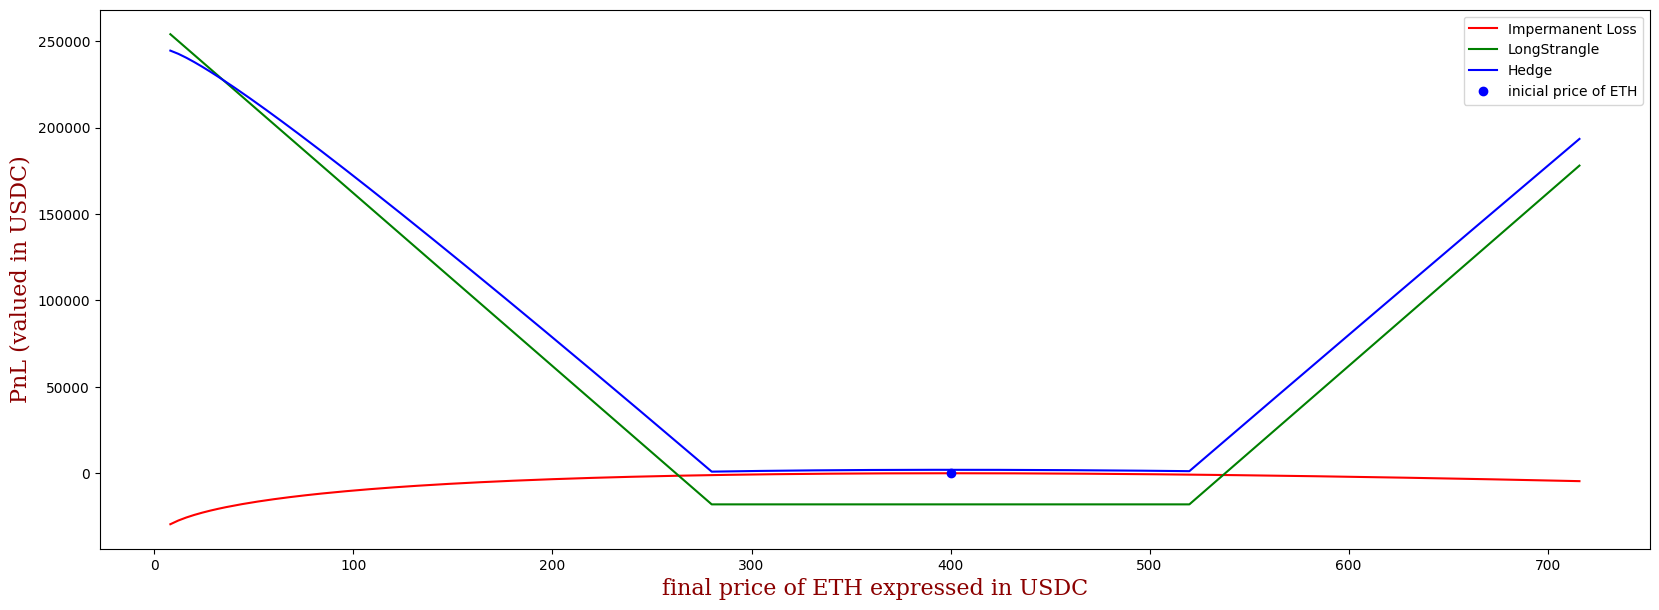

<class 'list'>
<class 'numpy.ndarray'>


In [16]:
# Chart generation
grid = np.arange(leftmost,rightmost,step)

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

fig = plt.figure(figsize = (20,7))
axs = fig.subplots(1)

r_pool = 0.25 # 0.002
P_entry = get_pool_initial_price(pool_balances)
V_hold_0 = get_pool_value(pool_balances, get_prices_vector(P_entry))
returns_usd_pool = r_pool * V_hold_0
costs = (call_qty*call_price)+(put_qty*put_price)
if costs > returns_usd_pool:
    print(f'WARNING: Pool fees: {returns_usd_pool} < Option costs {costs}')
axs.plot(grid*P_entry, IL_Y_P(grid*P_entry, pool_balances), c='red', label='Impermanent Loss')
axs.plot(grid*P_entry, payoff_CP_combination(grid*P_entry, strike_call, strike_put, call_price, put_price, call_qty, put_qty), c='green', label='LongStrangle')
axs.plot(grid*P_entry, payoff_IL_hedged_with_LS(grid*P_entry, pool_balances, initial_price, strike_call, strike_put, call_price, put_price, call_qty, put_qty, r_pool), c='blue', label='Hedge')

#axs.set_title('Profit and Loss', fontdict=font)
#plt.text(0,0, f'Fee = 0', fontdict=font)

axs.set_xlabel(f'final price of {pool_symbols[0]} expressed in {pool_symbols[1]}', fontdict=font)
axs.set_ylabel(f'PnL (valued in {pool_symbols[1]})', fontdict=font)
axs.plot(P_entry, 0, 'bo', label=f'inicial price of {pool_symbols[0]}')
#axs.set_ylim(-1000,1000)
axs.legend()
plt.show()

#grid2 = np.arange(-1, 2, 0.2)
#pd.DataFrame([[str(round(i*100,3))+'%',
#               str(round((i+1)*100,3))+'%',
#               str(round(abs(IL_Y_P(i+1, pool_balances)),1)*100)+'%'] for i in grid2],
#             columns = ['Price change', 'R', 'IL ratio']).T

#v1 = payoff_IL_hedged_with_LS_parcial(pool_balances, get_pool_initial_price(pool_balances), pool_return_at_final_time) * np.ones(len(grid))
#print(type(v1))
v2bis = [payoff_CP_combination(g*P_entry, strike_call, strike_put, call_price, put_price,call_qty,put_qty) for g in grid]
print(type(v2bis))
v3 = IL_Y_P(grid*P_entry, pool_balances)
print(type(v3))
v4 = v2bis+v3




#axs.plot(grid*P_entry, IL_Y_P(grid*P_entry, pool_balances), c='red', label='Impermanent Loss')
#axs.plot(grid*P_entry, payoff_CP_combination(grid*P_entry, strike_call, strike_put, call_price, put_price, call_qty, put_qty), c='green', label='LongStrangle')
#axs.plot(grid*P_entry, v1, c='red', label='Hedge1 - pool')
axs.plot(grid*P_entry, v2bis, c='green', label='Hedge2 - strangle')
axs.plot(grid*P_entry, v3, c='blue', label='Hedge3 - IL')
axs.plot(grid*P_entry, v4, c='orange', label='Hedge4 - Total')


## Practical example

### Obtaining Market Data

#### Get Quotes (dataset)

In this section we load the historical data.

##### Code

In [26]:
# This data is old. Must be update. Still the code works as a motivational example based on actual data.
ETH_historical=pd.read_csv('/content/ETHUSDC-1d-data.csv')
## Debugging:
#ETH_historical

# I keep the last maxnum records
P_ETH = ETH_historical['close']
for i in range(len(P_ETH)):
  P_ETH[i] = float(P_ETH[i])

print(len(P_ETH))


<ipython-input-26-595d364cf791>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P_ETH[i] = float(P_ETH[i])
<ipython-input-26-595d364cf791>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P_ETH[i] = float(P_ETH[i])
<ipython-input-26-595d364cf791>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P_ETH[i] = float(P_ETH[i])
<ipython-input-26-595d364cf791>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

318


##### Chart

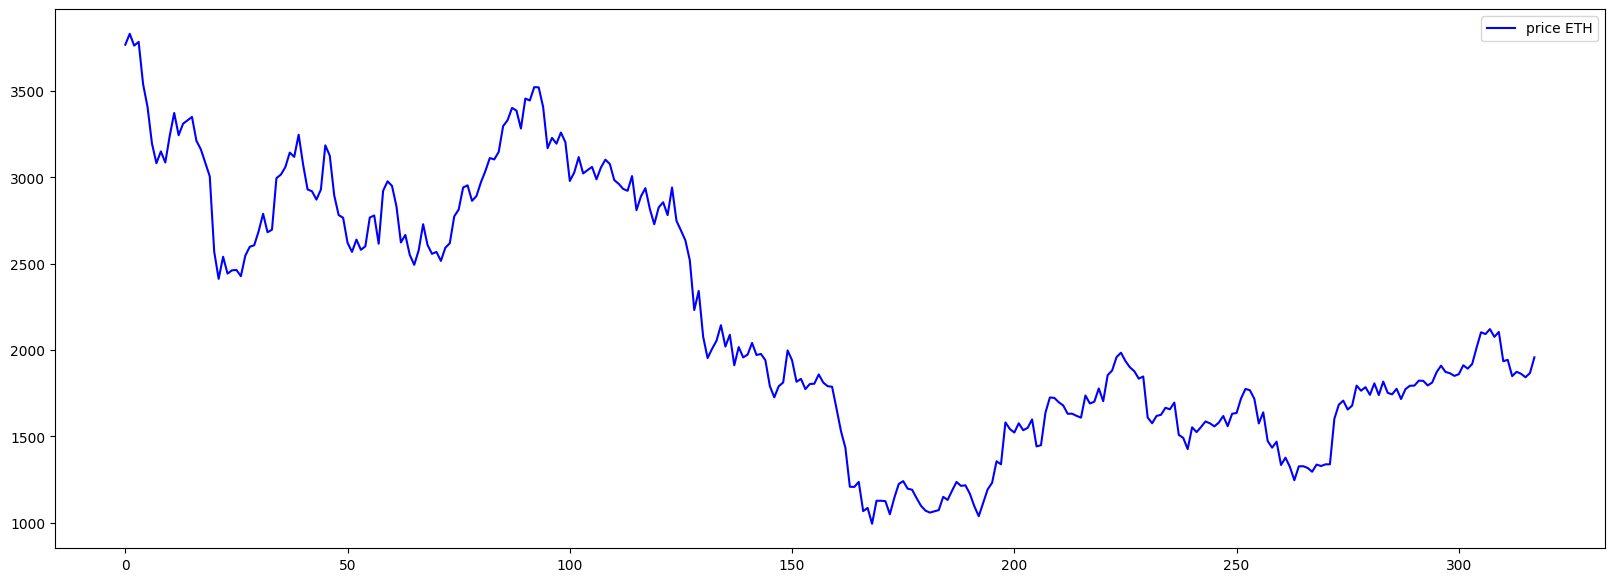

In [27]:
import matplotlib.pyplot as plt
# plt.plot(list(P_ETH))
# plt.figsize(20,7)
fig, axs = plt.subplots(1,1,figsize = (20,7))
axs.plot(list(P_ETH), c='blue', label = 'price ETH')
axs.legend()

#### Get quotes (Deribit)

In this section we have code to bring in options data and quotes from Deribit.


##### Parameters

In [22]:
## Parameters for retrieving options data from Deribit

instrument_name = "ETH" # BTC, ETH, or SOL

# Each ETH and BTC options contract on Deribit corresponds to a single
# underlying unit.

multiplier = 1

##### Code

In [28]:

import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


In [41]:

def get_all_instruments():
  import urllib.request, json
  url = f"https://test.deribit.com/api/v2/public/get_instruments"
  with urllib.request.urlopen(url) as url:
        data = json.loads(url.read().decode())
  return data

# Get a list of all active BTC options from the Deribit API.
def get_all_active_options(instrument_name="BTC"):
    import urllib.request, json
    url =  f"https://test.deribit.com/api/v2/public/get_instruments?currency={instrument_name}&kind=option&expired=false"
    with urllib.request.urlopen(url) as url:
        data = json.loads(url.read().decode())
    data = pd.DataFrame(data['result']).set_index('instrument_name')
    data['creation_date'] = pd.to_datetime(data['creation_timestamp'], unit='ms')
    data['expiration_date'] = pd.to_datetime(data['expiration_timestamp'], unit='ms')
    print(f'{data.shape[0]} active options.')
    return data

# Filter options based on data available from 'get_instruments'
def filter_options(price, active_options):
    # price is the current price of BTC

    #Get Put/Call information
    pc = active_options.index.str.strip().str[-1]

    # Set "moneyness"
    active_options['m'] = np.log(active_options['strike']/price)
    active_options.loc[pc=='P','m'] = -active_options['m']
    # Set days until expiration
    active_options['t'] = (active_options['expiration_date']-pd.Timestamp.today()).dt.days

    # Only include options that are less than 30% from the current price and have less than 91 days until expiration
    active_options = active_options.query('m>0 & m<.3 & t<91')

    print(f'{active_options.shape[0]} active options after filter.')
    return active_options

# Get Tick data for a given instrument from the Deribit API
def get_tick_data(instrument_name="BTC"):
    import urllib.request, json
    url =  f"https://test.deribit.com/api/v2/public/ticker?instrument_name={instrument_name}"
    with urllib.request.urlopen(url) as url:
        data = json.loads(url.read().decode())
    data = pd.json_normalize(data['result'])
    data.index = [instrument_name]
    return data

# Loop through all filtered options to get the current 'ticker' datas
def get_all_option_data(instrument_name="BTC"):
    option_data = get_tick_data(f'{instrument_name}-PERPETUAL')
    options = filter_options(option_data['last_price'][0], get_all_active_options(instrument_name))
    for o in options.index:
        option_data = pd.concat([option_data, get_tick_data(o)])
    return option_data



In [40]:
option_data = get_tick_data(f'{instrument_name}-PERPETUAL')
options = filter_options(option_data['last_price'][0], get_all_active_options(instrument_name))
for o in options.index:
  option_data = pd.concat([option_data, get_tick_data(o)])

<ipython-input-40-0ae2669c435f>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  options = filter_options(option_data['last_price'][0], get_all_active_options(instrument_name))


870 active options.
99 active options after filter.


<ipython-input-40-0ae2669c435f>:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  option_data = pd.concat([option_data, get_tick_data(o)])
<ipython-input-40-0ae2669c435f>:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  option_data = pd.concat([option_data, get_tick_data(o)])
<ipython-input-40-0ae2669c435f>:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining 

KeyboardInterrupt: 

In [82]:
option_data = get_all_option_data(instrument_name)

<ipython-input-41-d7945582b8cb>:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  options = filter_options(option_data['last_price'][0], get_all_active_options(instrument_name))


870 active options.
99 active options after filter.


<ipython-input-41-d7945582b8cb>:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  option_data = pd.concat([option_data, get_tick_data(o)])
<ipython-input-41-d7945582b8cb>:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  option_data = pd.concat([option_data, get_tick_data(o)])
<ipython-input-41-d7945582b8cb>:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determini

In [89]:
option_data['daystoexpiration']

,daystoexpiration
ETH-PERPETUAL,NaN
ETH-28MAR25-1600-P,NaN
ETH-28MAR25-1800-P,NaN
ETH-28MAR25-1900-P,NaN
ETH-28MAR25-2000-P,NaN
...,...
ETH-30MAY25-2300-C,NaN
ETH-30MAY25-2400-C,NaN
ETH-30MAY25-2500-C,NaN
ETH-30MAY25-2600-C,NaN


In [90]:
### Add additional metrics to data
option_data['daystoexpiration'] = np.nan; option_data['t'] = np.nan; option_data['strike'] = np.nan; option_data['callput'] = np.nan
# Calculated days until expiration
#option_data.loc[1:,'t'] = (pd.to_datetime(option_data[1:].index.map(lambda x: x.split('-')[1]))-pd.Timestamp.today()).days
option_data['daystoexpiration'][1:] = (pd.to_datetime(option_data[1:].index.map(lambda x: x.split('-')[1]))-pd.Timestamp.today()).days
option_data['t'][1:] = option_data[1:].index.map(lambda x: x.split('-')[1]).astype(str)
# Pull strike from instrument name
option_data['strike'][1:] = option_data[1:].index.map(lambda x: x.split('-')[2]).astype(int)
# pull callput
option_data['callput'][1:] = option_data[1:].index.map(lambda x: x.split('-')[3]).astype(str)
# Calculate "moneyness"
option_data['m'] = np.log(option_data['last_price'][0]/option_data['strike'])

<ipython-input-90-cc8ca4747fd8>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  option_data['daystoexpiration'][1:] = (pd.to_datetime(option_data[1:].index.map(lambda x: x.split('-')[1]))-pd.Timestamp.today()).days
<ipython-input-90-cc8ca4747fd8>:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single st

In [91]:
## Debugging:
# print(option_data)
# print(option_data.columns)
print(option_data['daystoexpiration'])

ETH-PERPETUAL          NaN
ETH-28MAR25-1600-P     0.0
ETH-28MAR25-1800-P     0.0
ETH-28MAR25-1900-P     0.0
ETH-28MAR25-2000-P     0.0
                      ... 
ETH-30MAY25-2300-C    63.0
ETH-30MAY25-2400-C    63.0
ETH-30MAY25-2500-C    63.0
ETH-30MAY25-2600-C    63.0
ETH-30MAY25-2700-C    63.0
Name: daystoexpiration, Length: 100, dtype: float64


##### Data obtained

In [92]:
print(option_data[(option_data.callput == 'C')]['last_price'])
print(option_data[(option_data.callput == 'P')]['last_price'])

ETH-28MAR25-2100-C    0.0009
ETH-28MAR25-2200-C    0.0001
ETH-28MAR25-2300-C    0.0001
ETH-28MAR25-2400-C    0.0001
ETH-28MAR25-2500-C    0.0001
ETH-28MAR25-2600-C    0.0001
ETH-28MAR25-2700-C    0.0298
ETH-29MAR25-2025-C    0.0180
ETH-29MAR25-2050-C    0.0115
ETH-29MAR25-2075-C    0.0080
ETH-29MAR25-2100-C    0.0040
ETH-29MAR25-2125-C    0.0017
ETH-29MAR25-2150-C    0.0023
ETH-29MAR25-2200-C    0.0011
ETH-29MAR25-2250-C    0.0002
ETH-30MAR25-2025-C    0.0155
ETH-30MAR25-2050-C       NaN
ETH-30MAR25-2075-C    0.0106
ETH-30MAR25-2100-C       NaN
ETH-30MAR25-2150-C       NaN
ETH-30MAR25-2200-C       NaN
ETH-4APR25-2100-C     0.0175
ETH-4APR25-2200-C     0.0085
ETH-4APR25-2300-C     0.0089
ETH-4APR25-2400-C     0.0020
ETH-4APR25-2500-C        NaN
ETH-4APR25-2600-C     0.0009
ETH-4APR25-2700-C        NaN
ETH-11APR25-2100-C    0.0305
ETH-11APR25-2200-C    0.0160
ETH-11APR25-2300-C    0.0090
ETH-11APR25-2400-C    0.0049
ETH-11APR25-2500-C    0.0308
ETH-11APR25-2600-C    0.0024
ETH-11APR25-27

### Choosing strikes for hedging


### Historical volatility calculation


We calculate the underlying asset's historical volatility based on data obtained from Binance to estimate the volatility value, which we will use to determine the hedge range. It can also be useful to use it in Black-Scholes, using BSM to select the best available option prices. The corresponding code is outlined in Appendix IV.


#### Code

In [93]:
def get_ema_std_vol_of_returns(hist_data, alpha, min_periods):
  # Rolling Volatility (annualized assuming 365 trading days)
  # 2 week
  # historical_data = hist_data[-2*30*24:].copy()
  historical_data = hist_data.copy()
  historical_data_return = np.around(historical_data.pct_change().dropna(), 3)
  ema_of_com_in_periods = historical_data_return.ewm(alpha=alpha, min_periods=min_periods)
  vol = ema_of_com_in_periods.std()
  historical_data_vol = vol
  vol_annualized = vol * np.sqrt(365)
  historical_data_vol_ann = vol_annualized
  return {'vol_ema_of_returns_respect_to_periods': vol,
          'vol_ema_of_returns_annualized': vol_annualized}

def get_ema_std_vol_of_prices(historical_data, alpha, min_periods):
  # Rolling Volatility (annualized assuming 365 trading days)
  # 2 week
  # historical_data['returns'] = np.around(historical_data['close'].pct_change().dropna(), 3)
  ema_of_com_in_periods = historical_data.ewm(alpha=alpha, min_periods=min_periods)
  vol = ema_of_com_in_periods.std()
  historical_data_vol = vol
  vol_annualized = vol * np.sqrt(365)
  historical_data_vol_ann = vol_annualized
  return {'vol_ema_of_prices_respect_to_periods': vol,
          'vol_ema_of_prices_annualized': vol_annualized}

#### Result

Using the data received from Binance to calculate historical volatility, we choose $P_i$ and $P_s$ as bounds for the [P_i,P_0] region of the PnL, which we intend to hedge.


In [94]:
sigma = np.mean(get_ema_std_vol_of_returns(P_ETH, 0.95, 15)['vol_ema_of_returns_respect_to_periods'])
#sigma = 5
security_factor = 5

print(f'sigma = {sigma}')
margin_to_hedge = sigma * security_factor
print(f'Margin for hedging: {margin_to_hedge}')

asset_price = option_data["underlying_price"][1] # last recorded price = Spot price (S)
P_s = asset_price*(1+margin_to_hedge)
P_i = asset_price*(1-margin_to_hedge)
print(f'P_s = {asset_price*(1+margin_to_hedge)}')
print(f'P_0 = {asset_price}')
print(f'P_i = {asset_price*(1-margin_to_hedge)}')


sigma = 0.037017699885714066
Margin for hedging: 0.18508849942857034
P_s = 2401.048554267255
P_0 = 2026.05
P_i = 1651.0514457327452


<ipython-input-94-d00087e9b21f>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  asset_price = option_data["underlying_price"][1] # last recorded price = Spot price (S)


#### We select the options


In the report, we show a result that ensures coverage in the interval $[P_i,P_s]$ provided that
\begin{align*}
\frac{c}{2}(\frac{1}{\sqrt{K_pP_0}} - \frac{1}{P_0})&\leq q_p\\
D-\min\{IL(K_c),IL(K_P)\}&\leq r_p c\\
-\frac{c}{2}(\frac{1}{\sqrt{K_c P_0}}-\frac{1}{P_0})&\leq q_c
\end{align*}
where $c$ is the initial capital; $q_p,q_c$ is the quantity of puts and calls to be purchased, respectively; and $D$ is the cost of the options.

Let's then filter the available options for a certain range of days and with strikes such that $K_p\in [P_i,P_0]$ and $K_c\in [P_0,P_s]$.

In [95]:

call_min_days_to_expiration = 20
call_max_days_to_expiration = 60
put_min_days_to_expiration = 20
put_max_days_to_expiration = 60

print(f'Option name\tDays to expiration')
print(option_data[(option_data.callput == 'C')&\
                  (option_data.daystoexpiration >= put_min_days_to_expiration)&
                  (option_data.daystoexpiration <= put_max_days_to_expiration)&\
                  (asset_price <= option_data.strike)&(option_data.strike <= P_s)])#['daystoexpiration'])

print(option_data[(option_data.callput == 'P')&\
                  (option_data.daystoexpiration >= put_min_days_to_expiration)&
                  (option_data.daystoexpiration <= put_max_days_to_expiration)&\
                  (asset_price >= option_data.strike)&(option_data.strike >= P_i)]['daystoexpiration'])

#option_data [option_data.strike == K_put]["instrument_name"]
#option_data [option_data.strike == K_call]["instrument_name"]

Option name	Days to expiration
                        timestamp state  index_price     instrument_name  \
ETH-18APR25-2100-C  1743088540477  open      2024.36  ETH-18APR25-2100-C   
ETH-18APR25-2200-C  1743088540477  open      2024.36  ETH-18APR25-2200-C   
ETH-18APR25-2300-C  1743088540477  open      2024.36  ETH-18APR25-2300-C   
ETH-18APR25-2400-C  1743088540477  open      2024.36  ETH-18APR25-2400-C   
ETH-25APR25-2100-C  1743088543498  open      2024.10  ETH-25APR25-2100-C   
ETH-25APR25-2200-C  1743088543498  open      2024.10  ETH-25APR25-2200-C   
ETH-25APR25-2300-C  1743088543498  open      2024.10  ETH-25APR25-2300-C   
ETH-25APR25-2400-C  1743088543498  open      2024.10  ETH-25APR25-2400-C   

                    last_price  settlement_price  min_price  max_price  \
ETH-18APR25-2100-C      0.0425          0.033325     0.0009     0.1465   
ETH-18APR25-2200-C         NaN          0.018966     0.0003     0.1205   
ETH-18APR25-2300-C      0.0169          0.011749     0.0001   


We filter the call and put options with
- expiration between the min and max days we defined earlier
- strike < P_s for the call
- strike > P_i for the put

In [96]:
call_options_available = option_data[(option_data.callput == 'C')&\
                  (option_data.daystoexpiration >= put_min_days_to_expiration)&
                  (option_data.daystoexpiration <= put_max_days_to_expiration)&\
                  (asset_price <= option_data.strike)&(option_data.strike <= P_s)]
put_options_available = option_data[(option_data.callput == 'P')&\
                  (option_data.daystoexpiration >= put_min_days_to_expiration)&
                  (option_data.daystoexpiration <= put_max_days_to_expiration)&\
                  (asset_price >= option_data.strike)&(option_data.strike >= P_i)]

In [97]:
call_options_available[['daystoexpiration', 'strike', 'mark_price']], P_s

(                    daystoexpiration  strike  mark_price
 ETH-18APR25-2100-C              21.0  2100.0      0.0412
 ETH-18APR25-2200-C              21.0  2200.0      0.0257
 ETH-18APR25-2300-C              21.0  2300.0      0.0160
 ETH-18APR25-2400-C              21.0  2400.0      0.0097
 ETH-25APR25-2100-C              28.0  2100.0      0.0499
 ETH-25APR25-2200-C              28.0  2200.0      0.0342
 ETH-25APR25-2300-C              28.0  2300.0      0.0227
 ETH-25APR25-2400-C              28.0  2400.0      0.0152,
 np.float64(2401.048554267255))

In [98]:
put_options_available[['daystoexpiration', 'strike', 'mark_price']], P_i

(                    daystoexpiration  strike  mark_price
 ETH-18APR25-1700-P              21.0  1700.0      0.0084
 ETH-18APR25-1800-P              21.0  1800.0      0.0177
 ETH-18APR25-1900-P              21.0  1900.0      0.0303
 ETH-18APR25-2000-P              21.0  2000.0      0.0503
 ETH-25APR25-1800-P              28.0  1800.0      0.0233
 ETH-25APR25-1900-P              28.0  1900.0      0.0375
 ETH-25APR25-2000-P              28.0  2000.0      0.0575,
 np.float64(1651.0514457327452))

In [115]:
# This cell has to be revised with the last options available
call = call_options_available[(call_options_available.daystoexpiration == max(call_options_available.daystoexpiration))&
                  (call_options_available.strike == 2100)]
put = put_options_available[(put_options_available.daystoexpiration == max(put_options_available.daystoexpiration))&
                  (put_options_available.strike == 1800)]

In [116]:
print(call["strike"])
print(put["strike"])

ETH-25APR25-2100-C    2100.0
Name: strike, dtype: float64
ETH-25APR25-1800-P    1800.0
Name: strike, dtype: float64


In [117]:
Kcall = float(call['strike'])
Kput = float(put['strike'])
dcall = float(call['mark_price']*asset_price)
dput = float(put['mark_price']*asset_price)
qcall = 100
qput = 100

<ipython-input-117-bbd8e98d0bc1>:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Kcall = float(call['strike'])
<ipython-input-117-bbd8e98d0bc1>:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Kput = float(put['strike'])
<ipython-input-117-bbd8e98d0bc1>:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dcall = float(call['mark_price']*asset_price)
<ipython-input-117-bbd8e98d0bc1>:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  dput = float(put['mark_price']*asset_price)


In [118]:
Kcall, Kput, dcall, dput, qcall, qput, dcall* qcall+ dput* qput

(2100.0, 1800.0, 101.099895, 47.206965000000004, 100, 100, 14830.686)

After reviewing that list, we choose the exercise date that appears on both the calls and puts (designating it by the number of days remaining until expiration).


### Chart

In [119]:
# Grid to plot
leftmost = 1-2*margin_to_hedge
rightmost = 1+2*margin_to_hedge
step = 0.01

In [120]:
# Libreries to use
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

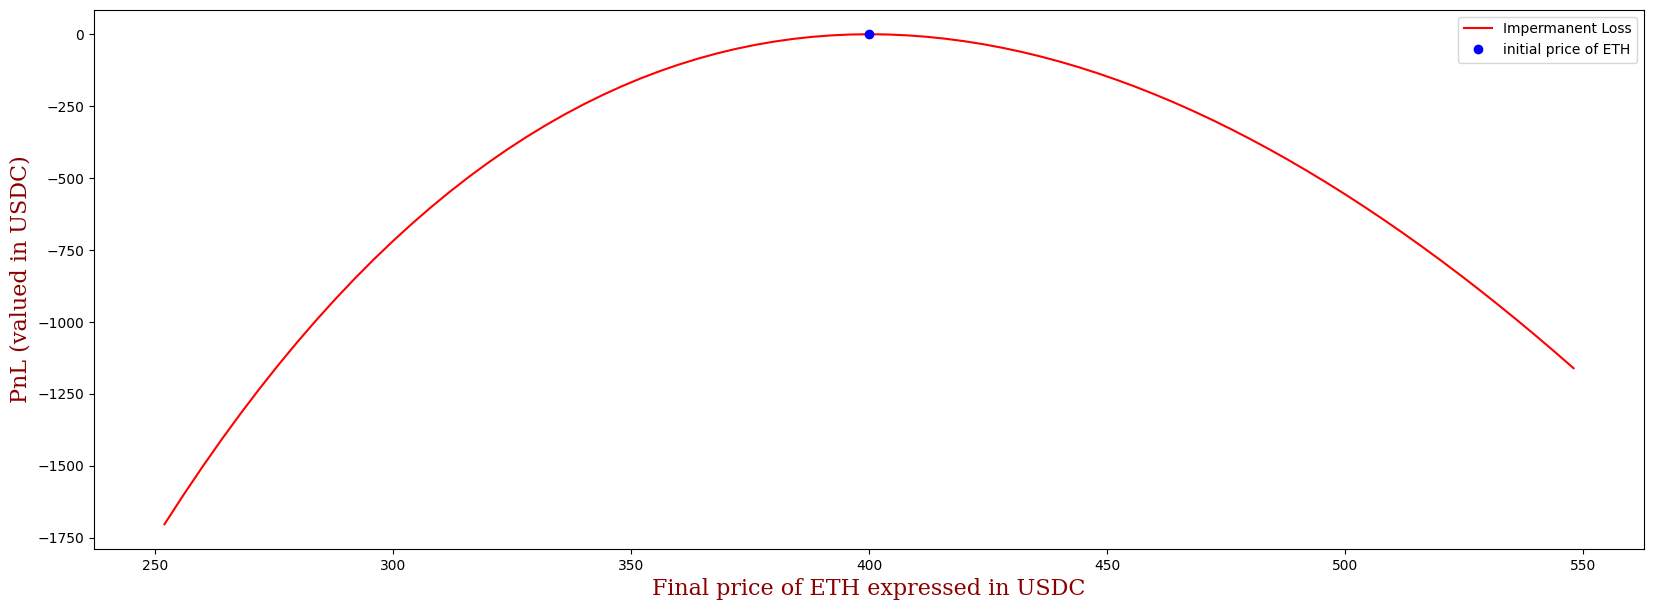

In [122]:
# Chart generation
grid = np.arange(leftmost,rightmost,step)

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

fig = plt.figure(figsize = (20,7))
axs = fig.subplots(1)

P_entry = get_pool_initial_price(pool_balances)
axs.plot(grid*P_entry, IL_Y_P(grid*P_entry, pool_balances), c='red', label='Impermanent Loss')

#axs.set_title('Profit and Loss', fontdict=font)
#plt.text(0,0, f'Fee = 0', fontdict=font)

axs.set_xlabel(f'Final price of {pool_symbols[0]} expressed in {pool_symbols[1]}', fontdict=font)
axs.set_ylabel(f'PnL (valued in {pool_symbols[1]})', fontdict=font)
axs.plot(P_entry, 0, 'bo', label=f'initial price of {pool_symbols[0]}')
axs.legend()
plt.show()

#grid2 = np.arange(-1, 2, 0.2)
#pd.DataFrame([[str(round(i*100,3))+'%',
#               str(round((i+1)*100,3))+'%',
#               str(round(abs(IL_Y_P(i+1, pool_balances)),1)*100)+'%'] for i in grid2],
#             columns = ['Price change', 'R', 'IL ratio']).T


Let's see how the final PnL looks.


In [123]:
def IL(p,bal_usdc, bal_eth, asset_price):
    v_0 = bal_usdc + bal_eth*asset_price
    return v_0/2 *((p/asset_price)**(1/2) - 1/2 - p/(2*asset_price))

In [124]:
price_change= np.arange(-1,3,0.01)

pool_balances = (100, asset_price*100)
balance_usdc = pool_balances[1]
balance_eth = pool_balances[0]
asset_price = balance_usdc/balance_eth
r_p = 0.15/12  # monthly ratio for providing liquidity
P = asset_price*(1+ price_change)
V_h_0 = balance_usdc + balance_eth*asset_price

In [125]:
V_h_0=balance_usdc + balance_eth*asset_price
cte_call=V_h_0/2*(1/np.sqrt(P_i*asset_price)-1/asset_price)
cte_put=-V_h_0/2*(1/np.sqrt(P_s*asset_price)-1/asset_price)

In [126]:
cte_call, cte_put

(np.float64(10.775769761444417), np.float64(8.14038767959828))

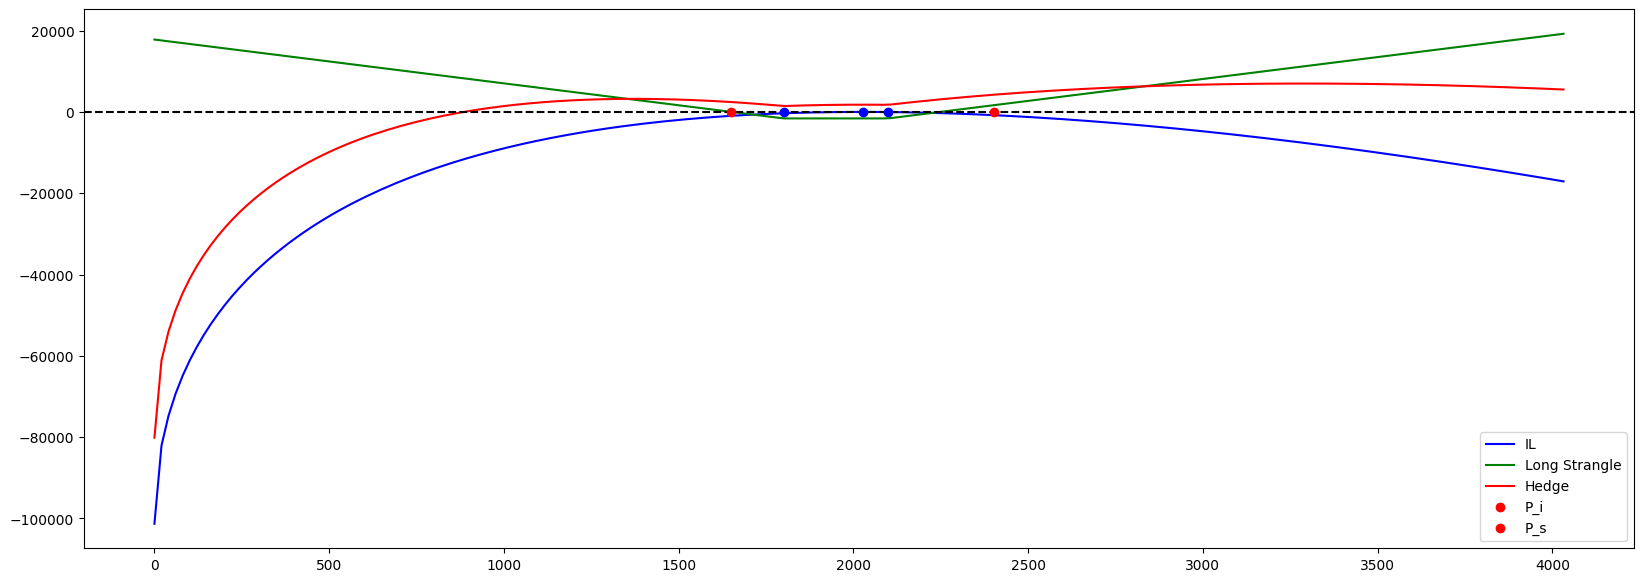

In [127]:
# Parameters
price_change= np.arange(-2*margin_to_hedge,2*margin_to_hedge,0.01)
price_change= np.arange(-1,1,0.01)

pool_balances = (100, asset_price*100)
balance_usdc = pool_balances[1]
balance_eth = pool_balances[0]
asset_price = balance_usdc/balance_eth

r_p = 0.1 / 12 # monthly return for providing liquidity
P = asset_price*(1+ price_change)
V_h_0 = balance_usdc + balance_eth*asset_price

pool_return_at_final_time=r_p* V_h_0

# Opt Parameters
K_put =  Kput
K_call =  Kcall
d_call = dcall
d_put = dput
q_call =  np.max([cte_put,cte_call])#qcall*np.ones(100)[0]
q_put = q_call  #qput*np.ones(100)[0]

# Stgy calcs
opt_stg = [payoff_CP_combination(p,K_call,K_put,d_call,d_put,q_call,q_put) for p in P]
IL_sin_hedg_usd = [IL(p, balance_usdc, balance_eth, asset_price) for p in P]
IL_con_hedg_usd = pool_return_at_final_time*np.ones(len(P)) + IL_sin_hedg_usd + opt_stg

# WARNING
costs = (q_call*dcall)+(q_put*dput)
if costs > pool_return_at_final_time:
    print(f'WARNING: Pools Fees: {pool_return_at_final_time} < Option Costs {costs}')


# Plot
fig, axs = plt.subplots(1,1,figsize = (20,7))
axs.plot(P, IL_sin_hedg_usd, c = 'blue', label = 'IL')
axs.plot(P, opt_stg, c = 'green', label = 'Long Strangle' )
axs.plot(P, IL_con_hedg_usd, c = 'red', label = 'Hedge')

axs.axhline(y = 0, color = 'black', linestyle = '--')
axs.plot(asset_price, 0, 'bo')
axs.plot(P_i, 0, 'ro', label='P_i')
axs.plot(P_s, 0, 'ro', label='P_s')
axs.plot(Kcall, 0, 'bo')
axs.plot(Kput, 0, 'bo')
# axs.set_xlim([1000,2000])
axs.legend()
plt.show()


Next, we print whether there is a hedge or not, comparing whether returns + IL < costs.

(False = Hedge is profitable; True = Hedge is not profitable)

In [128]:
print( q_call*dcall + q_put*dput- np.min([IL(K_call, balance_usdc, balance_eth, asset_price), IL(K_put, balance_usdc, balance_eth, asset_price)])-pool_return_at_final_time>= 0)

False


In [129]:
D = q_call*dcall + q_put*dput
V_h_0
print("Initial capital: ", V_h_0)
print("Total cost: ", D)
print("pcg: ", D/V_h_0)

Capital inicial:  405210.0
Costo total:  1598.1205774027708
pcg:  0.0039439317326886575


## Bibliography


<a name="referencia1">[1]</a> Angeris, Guillermo & Kao, Hsien-Tang & Chiang, Rei & Noyes, Charlie & Chitra, Tarun. (2020). An Analysis of Uniswap markets. Cryptoeconomic Systems. 10.21428/58320208.c9738e64.


## Appendix I: Notation


The notation used in the reference bibliography \[[1](#referencia1)\] is linked as follows to the one we use here:

$$ coins:\ (\alpha,\beta) \rightarrow (X, Y)$$
$$ time: t_1 , t_2,...,T \rightarrow 0, T \ ^{(*)}$$
$$ reserves\ for\ coin\ \alpha\ at\ time\ t_1: R_\alpha^{t_1} \rightarrow x_0 \ ^{(*)}$$
$$ reserves\ for\ coin\ \beta\ at\ time\ t_1\ ^{(**)}: R_\beta^{t_1} = \sqrt{k\ m_P^{t_1}}\rightarrow y_0 = \sqrt{k\ P_0}\ ^{(*)}$$
$$ reserves\ for\ coin\ \alpha\ at\ time\ T: R_\alpha^T \rightarrow x \ ^{(*)}$$
$$ reserves\ for\ coin\ \beta\ at\ time\ T\ ^{(**)}: R_\beta^T = \sqrt{k\ m_P^T} \rightarrow y = \sqrt{k\ P} \ ^{(*)}$$
$$ market\ price\ of\ coin\ \alpha\ at\ time\ t_1\ ^{(**)}: m_p^1 = R_\beta^{t_1} / R_\alpha^{t_1} \rightarrow P_0 = y_0 / x_0$$
$$ market\ price\ of\ coin\ \alpha\ at\ time\ T\ ^{(**)}: m_p^T = R_\beta^T / R_\alpha^T \rightarrow P = y / x $$
$$ constant\ product\ for\ all\ times\ t : k = R_\alpha^t \ R_\beta^t \rightarrow k = x\ y = x_0\ y_0$$
$$ liquidity\ provider's\ relative\ return\ between\ time\ t_1\ and\ T\ ^{(**)}: \delta = \sqrt{\frac{m_p^t}{m_p^1}} \rightarrow \sqrt{\frac{P}{P_0}}= \sqrt{R}$$
$$ total\ portfolio\ value\ ^{(**)}: P_V = 2 \sqrt{k m_P^T} \rightarrow V_{Pool_t} = 2 \sqrt{k P}$$


$^{(*)}$ See [note](#alcances) for the scope of this work.

$^{(**)}$ Equations valid only for the case without fees.



## Appendix II: Formulas for Impermanent Loss with fees


Here we present formulas and functions incorporating fees for calculating Impermanent Loss.

Let $fee=\tau$, $\phi = 1-\tau$, $P:=p^{bid^1}$ and $P_0:=p^{bid^0}$. Knowing that $p^b = \phi P_{Y|X} = \phi \frac{y}{x}$, $R=\frac{P_{Y|X}}{P^0_{Y|X}}=\frac{p^b}{p^b_0}$ and that $V_{Hold} = a+b*p^b$, we have


\begin{align*}
  IL^{fee}_{\%}(R) &= \sqrt{R}\frac{1+\phi}{\phi R+1} -1 \Rightarrow \frac{\partial}{\partial R}IL^{fee}_{\%}(R) = \frac{1+\phi}{(1+\phi R)^2}\frac{1-\phi R}{2\sqrt{R}}\\
  IL^{fee}_{\%}(P) &= \sqrt{PP_0}\frac{1+\phi}{P_0+\phi P}-1 \Rightarrow \frac{\partial}{\partial P} IL^{fee}_{\%}(P) = \frac{1+\phi}{2}\sqrt{\frac{P_0}{P}}\frac{P_0-\phi P}{(P_0+\phi P)^2}\\
  IL^{fee}_{USD}(P) &= IL^{fee}_{\%}(P)*V_{Hold} \text{ una forma} \\
  &= \frac{V_H^0}{2}\left(\sqrt{\frac{P}{P_0}}\frac{1+\phi}{\phi}-\frac{P_0+\phi P}{P_0\sqrt{\phi}}\right) \text{ otra forma} \Rightarrow \frac{\partial}{\partial P} IL^{fee}_{USD}(P) = \frac{V_H^0}{2P_0}\left(\frac{1}{2}\sqrt{\frac{P_0}{P}}\frac{1+\phi}{\phi}-\sqrt{\phi}\right)
\end{align*}

In [ ]:
# Percentage Impermanent Loss based on R with fees
def IL_R_fee(R,fee):
  phi = 1-fee
  return R**(1/2)*(1+phi)/(1+R*phi)-1
# Percentage Impermanent Loss based on P with fees
def IL_P_fee(P,fee):
  phi = 1-fee
  return IL_R_fee(P/P_entry,fee)
  # return (P*P_entry)**(1/2)*(1+phi)/(P_entry+phi*P)-1
# Impermanent Loss in USD based on P with fees
def IL_P_in_usd_fee(P,fee):
  phi = 1-fee
  # P = R * P_entry
  p_bid = P * phi
  p_bid_entry = P_entry * phi
  # p_bid_entry = P_entry * phi
  V_hold = tenencias_inicial[0] + tenencias_inicial[1] * p_bid
  V_hold_0 = tenencias_inicial[0] + tenencias_inicial[1] * p_bid_entry
  return V_hold_0/2 * ( (p_bid/p_bid_entry)**(1/2) * (1+phi)/phi - (p_bid_entry + phi*p_bid) / (p_bid_entry*phi**(1/2)) )
  # return IL_R_in_usd_fee(P/P_entry,fee)
# Percentage IL derivative based on R with fees
def IL_derivative_R_fee(R, fee):
  phi = 1-fee
  return (1+phi)/(1+phi*R)**2 * (1-phi*R)/(2*R**(1/2))
# Percentage IL derivative based on P with fees
def IL_derivative_P_fee(P,fee):
  phi = 1-fee
  p_bid_entry = P_entry * phi
  p_bid = P *  phi
  return IL_derivada_R_fee(P/P_entry, fee) / p_bid_entry
  # return (1+phi)/2 * (p_bid_entry/p_bid)**(1/2) * (p_bid_entry-phi*p_bid)/(p_bid_entry+phi*p_bid)**2
# USD IL derivative based on P with fees
def IL_derivative_P_in_usd_fee(P,fee):
  phi = 1-fee
  p_bid = P * phi
  p_bid_entry = P_entry * phi
  V_hold = tenencias_inicial[0] + tenencias_inicial[1] * p_bid
  V_hold_0 = tenencias_inicial[0] + tenencias_inicial[1] * p_bid_entry
  return IL_derivada_P_fee(P,fee) * V_hold + IL_P_fee(P, fee) * tenencias_inicial[1]
  # return V_hold_0/(2*p_bid_entry) * ( 1/2*(p_bid_entry/p_bid)**(1/2) * (1+phi)/phi - phi**(1/2) )

## Appendix III: Static Replicator for Constant Product Markets (CPM)

In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.stats import norm

In [ ]:
"""
european_option_bs
Def
European option price calculator using the Black Scholes model
Inputs
- type: string - Contract type between ["CALL","PUT"]
- S: float - Spot price of the asset
- K: float - Strike price of the contract
- T: float - Time to expiration (in years)
- r: float - Risk-free rate (annualized)
- sigma: float - Implied volatility (annualized)
- div: float - Continuous dividend rate (annualized)
Outputs
- price_BS: float - Contract price
"""

def european_option_bs(type, S, K, T, r, sigma, div):
#Define the ds
d1 = (np.log(S / K) + (r - div + 0.5 * sigma * sigma) * T) / sigma / np.sqrt(T)
    d2 = (np.log(S / K) + (r - div - 0.5 * sigma * sigma) * T) / sigma / np.sqrt(T)

    if (type == "C"):
        price_BS = np.exp(-div*T) *S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif (type == "P"):
        price_BS = K * np.exp(-r * T) * norm.cdf(-d2) - np.exp(-div*T) * S * norm.cdf(-d1)
    return price_BS


### Example: Replicating a CPM with bonds, futures and options

Consider a constant product market with state
$$ (t,R_a,R_b) = (1,10,200) $$

The price of $\beta$ in units of $\alpha$ is $m_p ^1 = \frac{R_\beta}{R_{\alpha}}$.
The initial pool value (in units of $\beta$) is
$$P_V ^1 = (m_p ^1 R_{\alpha}^{1}+R_{\beta}^{1})=0.005*200 + 10 = 20 $$

The replicating portfolio is:

Nominal value of the bond: $f(m^{0})= 2\sqrt{km^{0}}= 2\sqrt{2000*0.05}=20$

Notional value of futures $m^0$: $f'(m^0)=\sqrt{\frac{k}{m^{0}}}= \sqrt{\frac{2000}{0.05}}=200$

Notional value of options with strike $K$:  $f''(K)=-\frac{1}{2}\sqrt{\frac{k}{K^3}} dK = -\frac{0.0125}{2}\sqrt{\frac{2000}{K^3}} dK$


If, for example, we have a discrete number of strikes $K=(0.125, 0.025, . . . , 0.1)$, the payoff at expiration is left

$$
    P_V^{T}=f(m^0)+f'(m^0)(m^T-m^0)+
     \sum _{K\leq m_p ^{0}}f''(K)P(K)\Delta K +\sum _{K>m_p ^0} f''(K)C(K)\Delta K.
$$

In [ ]:
def face_value_bond (x, k):
    return 2*np.sqrt(k*x)
def notional_future (x, k):
    return np.sqrt(k/x)
def notional_option (x, delta_x, k):
    return -(1/2)*np.sqrt(k/(x**3))*(delta_x)


def replicator_with_option_discr_bs(m_T, m_0, K, k):
    # Parámetros para las opciones
    T = 1
    r = 0.1
    div = 0
    sigma = 0.2
    bond = face_value_bond(m_0, k)
    futures = notional_future(m_0,k)*(m_T-m_0)
    sum_calls = 0
    sum_puts = 0
    for i in range(1, len(K)):
        if K[i] > m_0:
            sum_calls = sum_calls + notional_option(K[i],K[i]-K[i-1],k)*european_option_bs("C", m_T, K[i], T, r , sigma, div)
        else:
            sum_puts = sum_puts + notional_option(K[i],K[i]-K[i-1],k)*european_option_bs("P", m_T, K[i], T, r , sigma, div)
    return bond + futures + sum_calls + sum_puts

In [ ]:
S = np.linspace(0, 0.1, 6) # rango a graficar
m_0 = 0.05
k= 2000
# strikes
K = np.linspace(0.0125,0.1,8)

replicator_discr_bs = replicator_with_option_discr_bs(S,m_0,K,k)
#Grafico el Strangle

fig, axs = plt.subplots(1,1,figsize = (20,7))
axs.plot(S, replicator_discr_bs, c = 'blue', label = 'replicated payoff')
axs.plot(S, 2*np.sqrt(k*S), c = 'red', label = 'P_V ^T')
axs.axhline(y = 0, color = 'black', linestyle = '--')
axs.legend()
plt.plot()


## Appendix IV: Valuation of European Options Using BSM

Although we had intended to use the Black-Scholes-Merton model in conjunction with historical volatility to determine whether the option prices we obtained were reasonably priced or not, we ultimately decided not to do so to limit the length of the work. It can also be used to calculate the theoretical volatility that would correspond to the observed prices.


### Code

In [ ]:
!pip install QuantLib

In [ ]:

### Modeling European Options with BSM (QuantLib)

import numpy as np
import QuantLib as ql
from QuantLib.QuantLib import nullInt
from pandas.core.base import DataError
from datetime import timedelta, datetime

def payoff(type, price, strike):
  if type == 'CALL':
  option_type = ql. Option. Call
  elif type == 'PUT':
  option_type = ql. Option. Put
  return ql. PlainVanillaPayoff(option_type, strike)

def constant_rate(valuation_date, interest_rate):
  return ql. YieldTermStructureHandle(ql. FlatForward(valuation_date, interest_rate,
  ql. Actual365Fixed()))

def get_rate_value(rate_object, expiration_date):
  return rate_object. forwardRate(rate_object. valuation_date,
  expiration_date,
  ql. Actual365Fixed(),
  ql. Continuous). rate()

def volatility(valuation_date, calendar, volatility_value):
  return ql. BlackVolTermStructureHandle(
  ql. BlackConstantVol(valuation_date,
  calendar,
  volatility_value,
  ql. Actual365Fixed()
  )
  )

def get_volatility_value(volatility_object, expiration_date, base):
  return volatility_object. BlackVol(expiration_date, base)

def BSM_process(asset_price, valuation_date, volatility_value, interest_rate, dividend_rate, calendar):
  ql. Settings. instance(). evaluationDate = valuation_date
  spot_object = ql. QuoteHandle(ql. SimpleQuote(asset_price))
  interest_rate_object = constant_rate(valuation_date, interest_rate)
  dividend_rate_object = constant_rate(valuation_date, dividend_rate)
  volatility_object = volatility(valuation_date, calendar, volatility_value)
  return ql.BlackScholesMertonProcess(spot_object,
  dividend_rate_object,
  interest_rate_object,
  volatility_object)

def price_european_option_bsM(type, price, basis, expiration, BSM_process):
  European_exercise = ql.EuropeanExercise(expiration)
  European_option = ql.VanillaOption(payoff(type, price, basis),
  European_exercise)
  European_option.setPricingEngine(ql.AnalyticEuropeanEngine(BSM_process))
  return max(European_option.NPV(),0)


### Parameters

In [ ]:
volatility_value = 0.3394 #Annualized Implied Volatility (sigma)
interest_rate = 0.0325 #Annualized Risk-Free Rate (r) - volume US02Y
dividend_rate = 0.0 #Annualized Dividend Rate (q)

##Valuation on July 18, 2022
#valuation_date = ql.Date(18, 7, 2022)
##Valuation with today's date
valuation_date = datetime.now()
valuation_date = ql.Date(int(valuation_date.strftime('%d')),
int(valuation_date.strftime('%m')),
int(valuation_date.strftime('%Y')))
#valuation_date = ql.Date(28,7,2022)
##Expiration on August 16, 2022
expiration_date = ql.Date(28, 8, 2022)
# US Market
calendar = ql.UnitedStates()

### Results

In [ ]:
asset_price = option_data["underlying_price"][1]
print("European ETH option prices evaluated as of date " +
str(valuation_date) +
" knowing that: \n" +
"\tcurrent price " + str(asset_price) + "\n" +
"\tvolatility " + str(volatility_value) + "\n" +
"\trisk-free rate " + str(interest_rate) + "\n" +
"\tdividend rate " + str(dividend_rate))

for (basis, rate) in (K_put, 'PUT'), (K_call, 'CALL'):
print("European option price " + str(rate) + "strike" +
str(basis) +" expiration "+ str(expiration_date) +" according to BSM: "+
            str(price_european_option_bsM(type,
                                      asset_price,
                                      base,
                                      base,
                                      expiration_date,
                                      BSM_process(asset_price,
                                      valuation_date,
                                      volatility_value,
                                      interest_rate,
                                      dividend_rate,
                                      calendar)
                                      )
               )
            )


